In [105]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import os 
import string

# Read in the study data

In [11]:
study_data = pd.read_csv(
    os.path.join('..','data','cat_output','input_equity_210216.csv'),
    index_col = 0
)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (3,6,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Function to compute ECDF

In [13]:
def compute_weighted_percentile(data, perc, weights):
    perc = perc
    ix = np.argsort(data)
    data = data[ix]
    weights = weights[ix]
    cdf = (np.cumsum(weights) - 0.5 * weights) / np.sum(weights)
    result = np.interp(perc, cdf, data)
    return result

In [14]:
emi_col = 'Emissions_allocation_(MtCO2e)'

# Create the clusters

In [15]:
study_data.loc[:,'weight'] = None
study_data.loc[:,'Cluster'] = (
    study_data.loc[:, 'Category']
    +
    study_data.loc[:,'Stab_level_ID'] 
)


# Select a country for illustration 

In [16]:
iso = 'IND'

In [17]:
mask_iso = study_data.loc[:,'Country_ID'] == iso
mask_year = study_data.loc[:,'Year'] == 2030

In [18]:
data_iso = study_data.loc[mask_iso & mask_year,:]

In [20]:
data_iso.head()

Country_ID             Study_ID   Regime_ID Uncertainty_ID Stab_level_ID  \
184        IND   001_den_Elzen_2012  CDC_AI_80%  Best_estimate       450_ppm   
185        IND   001_den_Elzen_2012  CDC_AI_85%  Best_estimate       450_ppm   
186        IND   001_den_Elzen_2012  CDC_AI_90%  Best_estimate       450_ppm   
187        IND   001_den_Elzen_2012  CDC_AI_95%  Best_estimate       450_ppm   
646        IND  002_van_Vuuren_2010    C&C_2050  Best_estimate       450_ppm   

           Starting_point_ID     Gas_ID      Sectors_ID  Year  \
184             2020_pledges  All_Gases  All_excl._LUCF  2030   
185             2020_pledges  All_Gases  All_excl._LUCF  2030   
186             2020_pledges  All_Gases  All_excl._LUCF  2030   
187             2020_pledges  All_Gases  All_excl._LUCF  2030   
646  2010_KP_target_excl._US  All_Gases  All_excl._LUCF  2030   

     Emissions_allocation_(MtCO2e)  ... Source  harmonized  \
184                    3027.125422  ...    NCI        True   
185                    3062.002133  ...    NCI        True   
186                    3093.167364  ...    NCI        True   
187                    3126.957241  ...    NCI        True   
646                    3297.301500  ...    NCI        True   

     Emissions_during_base_year Reference_emissions_during_base_year  \
184                 2847.680367                            2175.4600   
185                 2847.680367                            2175.4600   
186                 2847.680367                            2175.4600   
187                 2847.680367                            2175.4600   
646                 2463.007800                            1906.8536   

     Raw_emissions_allocation_(MtCO2e)  index   ID  Criteria  weight  \
184                        3962.511667    NaN  NaN       NaN    None   
185                        4008.165333    NaN  NaN       NaN    None   
186                        4048.960667    NaN  NaN       NaN    None   
187                        4093.191667    NaN  NaN       NaN    None   
646                        4258.994667    NaN  NaN       NaN    None   

             Cluster  
184    Staged450_ppm  
185    Staged450_ppm  
186    Staged450_ppm  
187    Staged450_ppm  
646  Equality450_ppm  

[5 rows x 23 columns]

In [21]:
for i_cluster, cluster in enumerate(study_data.Cluster.unique()):
    mask = data_iso.loc[:,'Cluster'] == cluster
    count_members = sum(mask)
    if count_members > 0:
        data_iso.loc[mask,'weight'] = 1/count_members
    else:
        data_iso.loc[mask,'weight'] = 0 

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [24]:
data_iso.loc[:,'weight']=(
    data_iso.loc[:,'weight']  
    / 
    (data_iso.loc[:,'weight'].sum()) 
).astype(float)
sort_df = data_iso.sort_values(emi_col)
sort_df.loc[:,'cum_weight'] = sort_df.loc[:,'weight'].cumsum()
sort_df.loc[:,'cum_non_weight'] = (sort_df.loc[:,'weight']*0+1).cumsum() / len(sort_df.loc[:,'weight'])
sort_df.index = range(len(sort_df.index))

<IPython.core.display.Javascript object>


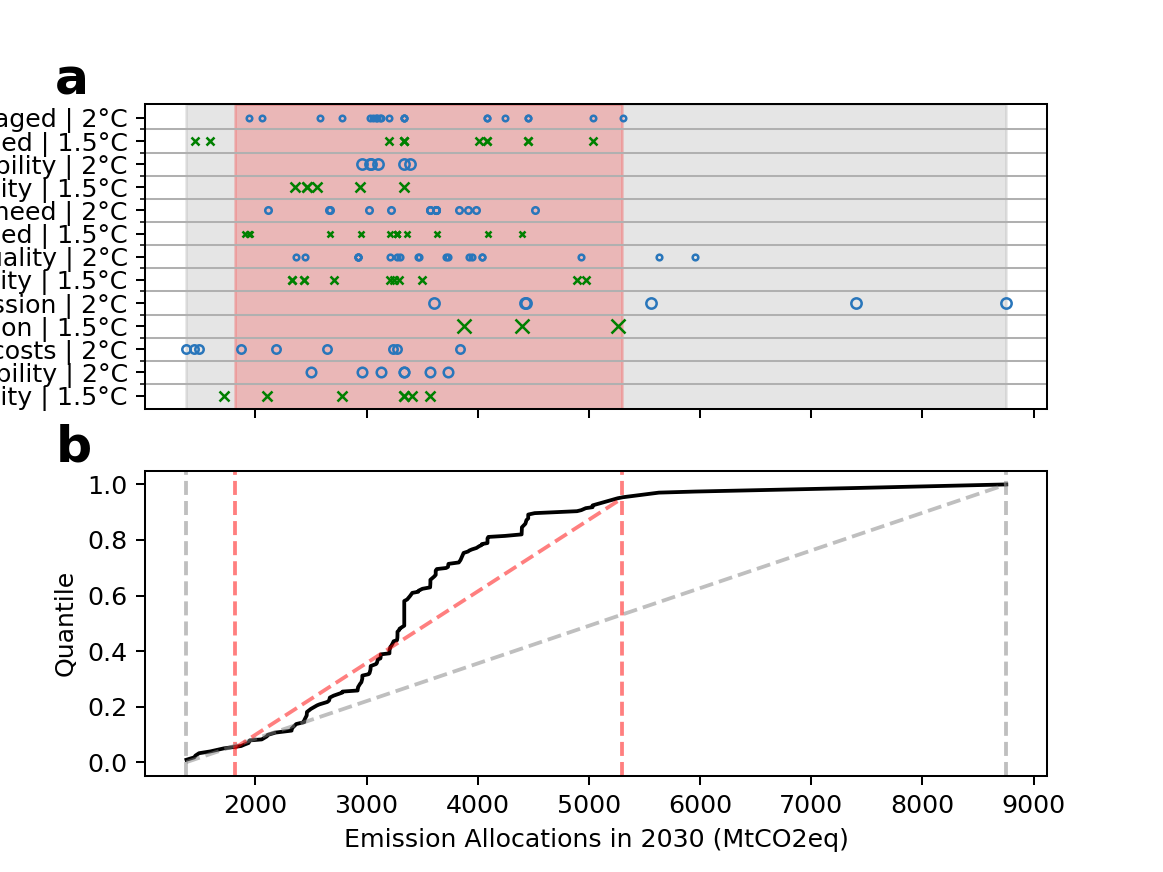

In [118]:
%matplotlib notebook
fig, ax = plt.subplots(2,1, sharex=True)

In [119]:
# Adding the datapoints 
cluster_list = list(study_data.Cluster.unique())
cluster_list.sort()

In [120]:
for i, cluster in enumerate(cluster_list):
    mask = data_iso.loc[:,'Cluster'] == cluster
    count = sum(mask)
    if '400' in cluster:
        color = 'green'
        marker = 'x'
    else:
        color = 'xkcd:bluish'
        marker = 'o'
    if count > 0:
        ax[0].plot(
            data_iso.loc[mask,emi_col],
            [i] * sum(mask),
            'd',
            markersize = 10 * np.sqrt(1/count),
            color = color,
            fillstyle = 'none',
            marker = marker
        )

In [121]:
cluster_labels = [
    x
    .replace('450_ppm', ' | 2°C')
    .replace('400_ppm',' | 1.5°C')
    .replace('Eq._cumulative_per_capita_emissions', 'Cum per capita emission') 
    for x in cluster_list
]
ax[0].set_yticks(range(i+1))
ax[0].set_yticklabels(labels = cluster_labels)
ax[0].set_yticks([x+.5 for x in range(i)], minor=True)
ax[0].yaxis.grid(True, which='minor')

In [122]:
ax[1].plot(sort_df.loc[:,emi_col], sort_df.loc[:,'cum_weight'], color='black')

In [123]:
# Add min/max span in upper and line for lower 
_min = sort_df.loc[:,emi_col].min()
_max = sort_df.loc[:,emi_col].max()

ax[1].axvline(_min, color='grey', linestyle='dashed', alpha = 0.5)
ax[1].axvline(_max, color='grey', linestyle='dashed', alpha = 0.5)
ax[0].axvspan(_min,_max, color='grey',alpha=0.2)

In [124]:
# Added weighted percentile cuts 
p5 = compute_weighted_percentile(sort_df.loc[:,emi_col], 5 / 100., sort_df.loc[:,'weight'])
p95 = compute_weighted_percentile(sort_df.loc[:,emi_col], 95 / 100., sort_df.loc[:,'weight'])

ax[1].axvline(p5, color='red', linestyle='dashed', alpha=0.5)
ax[1].axvline(p95, color='red', linestyle='dashed', alpha=0.5)
ax[0].axvspan(p5,p95, color='red',alpha=0.2)

In [125]:
ax[1].set_ylabel('Quantile')
ax[1].set_xlabel('Emission Allocations in 2030 (MtCO2eq)')

Text(0.5, 44.222222222222186, 'Emission Allocations in 2030 (MtCO2eq)')

In [126]:
# Add line between min and max 
ax[1].plot([_min,_max],[0,1],'--b',color='grey',alpha=0.5)
ax[1].plot([p5,p95],[0.05,0.95],'--b',color='red',alpha=0.5)

In [127]:
for n, ax in enumerate(ax):
    ax.text(-0.1, 1.03, string.ascii_lowercase[n], transform=ax.transAxes, 
            size=20, weight='bold')

In [128]:
fig.savefig(
    os.path.join(
        '..','figures','s231_fair_share_range.png'
    ),
    dpi=600,
    bbox_inches='tight'
)